# STA Problem Set

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pprint
from scipy.io import loadmat

## Load the Data

In [30]:
d = loadmat('LGN_FFdata.mat')
spiks = d['FFspks'][0] # number is number of seconds from the start for that spike
stims = d['FFstim'] # TODO: there seems to be an extra 0 at the end of stims which is messing stuff up
dt = d['DTstim'][0] # time between each stimulus

## 1. Temporal receptive field of a neuron

### A. Average stimulus value for all spike times

In [31]:
# bin the spiks by their associated stims
def associate_spiks_to_stims(spiks, stims, dt):
    max_stim = len(stims) * dt
    # put a tiny amount of extra time at the end of the bin to make sure that we include the extreme times
    epsilon = dt / 2
    return np.histogram(spiks, bins=np.arange(0, max_stim+epsilon, dt), range=(0, max_stim))[0]


# combine the spiks and stims by as columns
def merge_spiks_and_stims(spiks, stims, dt):
    spiks_per_stim = associate_spiks_to_stims(spiks, stims, dt)
    return np.column_stack([stims.flatten(), spiks_per_stim])

In [33]:
merged = merge_spiks_and_stims(spiks, stims, dt)

# average stimulus for all spike times
np.sum(merged[:,0] * merged[:,1]) / np.sum(merged[:,1])

0.05954608809527265

### B. STA of the neuron

In [34]:
# moving window across the binned spikes, in 100ms (.1) bins
num_lags = math.ceil(.1 / dt)

In [35]:
# shifts vector by the amount (shift can be positive or negative)
# fills the empty elements with zeros
def shift_vector(vector, shift):
    if shift > len(vector):
        shift = len(vector)
    elif shift < 0 and abs(shift) > len(vector):
        shift = -len(vector)
    
    if shift > 0:
        shifted = np.concatenate((np.zeros((shift)), vector[:-shift]), axis=None)
    elif shift < 0:
        shifted = np.concatenate((vector[abs(shift):], np.zeros((abs(shift)))), axis=None)
    else:
        shifted = vector
    
    return shifted


def calc_sta(merged, num_lags):
    sta = []
    for lag in range(0, num_lags):
        lagged_stim = shift_vector(merged[:,0], lag)
        sta.append(np.sum(lagged_stim * merged[:,1]) / np.sum(merged[:,1]))
    sta = np.array(sta)
    return sta

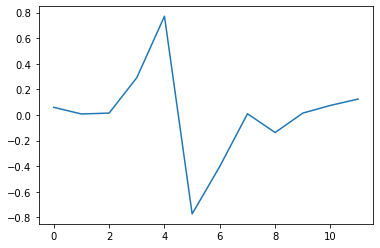

In [36]:
sta = calc_sta(merged, num_lags=12)
plt.plot(sta)

## 2. Calculating the spiking nonlinearity

### A. Calculate the stimulus convolved with the receptive field

In [37]:
def kernel_response(stims, kernel):
    # pad the stims with zeros to be able to use the kernel from the start of the stims
    padded_stims = np.concatenate((np.zeros((len(kernel)-1)), stims), axis=None)
    
    # slide the window over the stims
    # TODO: change to the matrix method for better bookkeeping
    filtered_stims = []
    for i in range(len(kernel), len(padded_stims)+1):
        filtered_stims.append(np.dot(padded_stims[i-len(kernel):i], kernel))
    return np.array(filtered_stims)


# test that the kernel response does what we expect in the happy path
def test_kernel_response_happy():
    test_kernel = np.array([0, 0.5, 1])
    test_stims = np.array([1, 2, 4, 2, 4, 6])
    
    return kernel_response(test_stims, test_kernel)


test_kernel_response_happy()

array([1. , 2.5, 5. , 4. , 5. , 8. ])

In [38]:
def g_convolve( s, k ):
    # pad to make causal
    k2 = np.zeros(len(k)*2-1)
    k2[len(k)-1:] = [i for i in k]
    g = np.convolve( s, k2, mode='same')
    return g


# test that the g_convolve does what we expect in the happy path
def test_g_convolve_happy():
    test_kernel = np.array([0, 0.5, 1])
    test_stims = np.array([1, 2, 4, 2, 4, 6])
    
    return g_convolve(test_stims, test_kernel)


test_g_convolve_happy()

array([0. , 0.5, 2. , 4. , 5. , 4. ])

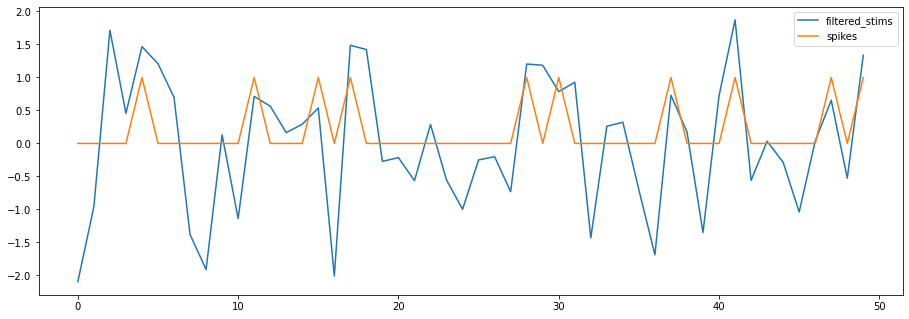

In [39]:
filtered_stims = g_convolve(stims[:,0], sta)
#filtered_stims are g

g = sta / np.std(filtered_stims)

filtered_stims_normed = g_convolve(stims[:,0], g)

axt = plt.axes([1, 1, 2, 1])
axt.plot(filtered_stims[50:100], label='filtered_stims')
axt.plot([r for s,r in merged[50:100]], label='spikes')
axt.legend()
plt.show()

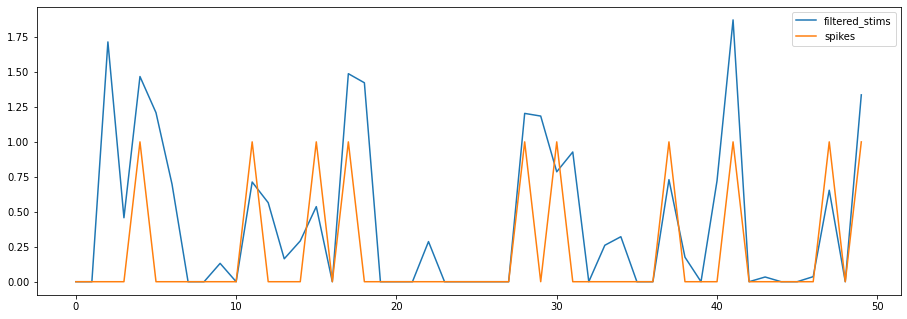

In [40]:
# remove negative values from the filter response
nonneg_filtered_stims = list(map(lambda x: x if x >= 0 else 0, filtered_stims))

axt = plt.axes([1, 1, 2, 1])
axt.plot(nonneg_filtered_stims[50:100], label='filtered_stims')
axt.plot([r for s,r in merged[50:100]], label='spikes')
axt.legend()
plt.show()

### B. Calculate the histogram for the value of the filtered stimulus

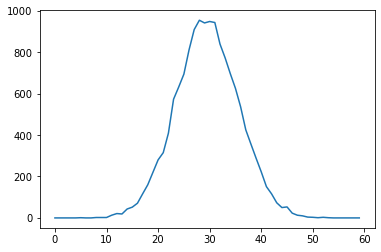

In [41]:
histb = np.histogram(filtered_stims, bins=np.arange(-6, 6.2, 0.2))[0]
plt.plot(histb)

### C. Calculate the histogram for the value of the filtered stimulus for just the spike times

In [42]:
# filter the filtered_stims for just when there is a spike
indices_when_spiking = (merged[:,1] > 0).nonzero()[0]
indices_when_spiking

array([    8,    16,    23, ..., 14377, 14383, 14390])

In [43]:
# NOTE: this is wrong, we don't just want g(stim) when there is a spike,
#       we want to multiply the value of g by the number of spikes
filtered_stims_when_spiking = filtered_stims[indices_when_spiking]
histc = np.histogram(filtered_stims_when_spiking, bins=np.arange(-6, 6.2, 0.2))[0]

In [44]:
filtered_stims_when_spiking = np.min(merged[:,1]) * filtered_stims
histc = np.histogram(filtered_stims_when_spiking, bins=np.arange(-6, 6, 0.2))[0]
len(filtered_stims_when_spiking), len(filtered_stims)

(14391, 14391)

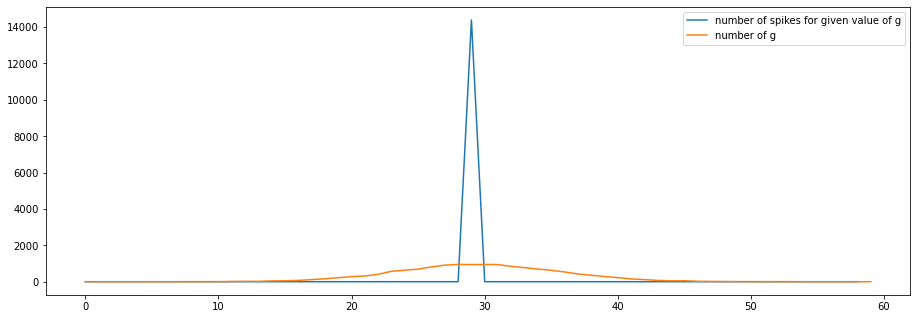

In [45]:
axc = plt.axes([1, 1, 2, 1])
axc.plot(histc, label='number of spikes for given value of g')
axc.plot(histb, label='number of g')
axc.legend()
plt.show()

### D. Plot the spiking nonlinearity

In [27]:
# TODO: add a tiny jitter to the zeros in histb and histc to prevent divide by zero errors, maybe

plt.plot(histc / histb)

ValueError: operands could not be broadcast together with shapes (59,) (60,) 